# 2nd NOTEBOOK: Train your Cryo Injury segmentation Unet

In [3]:
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

import cv2
import segmentation_models as sm
from livelossplot import PlotLossesKeras
import os
import numpy as np
from skimage.io import imsave,imshow,imread
import skimage
from skimage.exposure import rescale_intensity

import PIL

import segmentation_models as sm

import datetime
import shutil

import sys
sys.path.append(r'.\Modules')

import trainDataLoader as TDL
sm.set_framework('tf.keras')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Enter location of the Data folder as created in "Data Preparation Notebook"

In [4]:
path_data = r"D:\Prateek\Nick\DeepLearningTraining"
BACKBONE = 'resnet18'
BATCH_SIZE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

# 2. Initialize the Training and Validation Generators
<b> = X Images

<b> = y Annotations

In [5]:
x_train_dir = os.path.join(path_data, "Images", "Images")
y_train_dir = os.path.join(path_data, "Annotations","Annotations")

train_dataset = TDL.Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=TDL.get_training_augmentation(),
    preprocessing=TDL.get_preprocessing(preprocess_input),
)

x_valid_dir = os.path.join(path_data, "Images", "Images_Validation")
y_valid_dir = os.path.join(path_data, "Annotations", "Annotations_Validation")

# Dataset for validation images
valid_dataset = TDL.Dataset(
    x_valid_dir, 
    y_valid_dir,  
    augmentation=TDL.get_validation_augmentation(),
    preprocessing=TDL.get_preprocessing(preprocess_input),
)

C:\Users\pa20c964\Miniconda3\envs\AI_Cryoinjuries\lib\site-packages\albumentations\augmentations\transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# 3. Define the training parameters
Here are many parameters that can be adjusted to get the best model

In [6]:
# working with sm.model resnet18 and image as integer

train_dataloader = TDL.Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = TDL.Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

cls_weights = np.array([0.5,1.,1.5])
jacc_loss = sm.losses.JaccardLoss(class_weights=cls_weights, class_indexes=None, per_image=False, smooth=1e-05)
dice_loss  = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (2 * focal_loss)

num_classes = 3
backbone=BACKBONE
pat=50
lr=0.0001
activation= 'softmax'
loss_func= (total_loss,'dice_loss_plus_2focal_loss')
training_size = train_dataloader.__len__()*BATCH_SIZE
# batch_size= batch_size defined with input
epochs = 350
vsteps = valid_dataloader.__len__()
epsteps = train_dataloader.__len__()
comment = "_nick_slide_scanner_15112022"
model_name = "bb_{}__trainSz_{}__lossfun_{}__lr_{}__act_{}__batchsz_{}__pat-{}__epo-{}_vstep-{}_epstep-{}_comment{}".format(backbone, training_size,loss_func[1], lr,activation,BATCH_SIZE,pat,epochs,vsteps,epsteps,comment)
print(model_name)#.rsplit("_",18)[0])

model = sm.Unet(backbone, input_shape=(512, 512, 3),classes=3, encoder_weights=None,activation=activation)
model.compile(optimizer=Adam(learning_rate=lr), loss=loss_func[0],metrics=["Accuracy",dice_loss,jacc_loss])

bb_resnet18__trainSz_180__lossfun_dice_loss_plus_2focal_loss__lr_0.0001__act_softmax__batchsz_30__pat-50__epo-350_vstep-2_epstep-6_comment_nick_slide_scanner_15112022


# 4. Check whether everything is okay with the Data

In [7]:
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 3)

# 5. Train your model

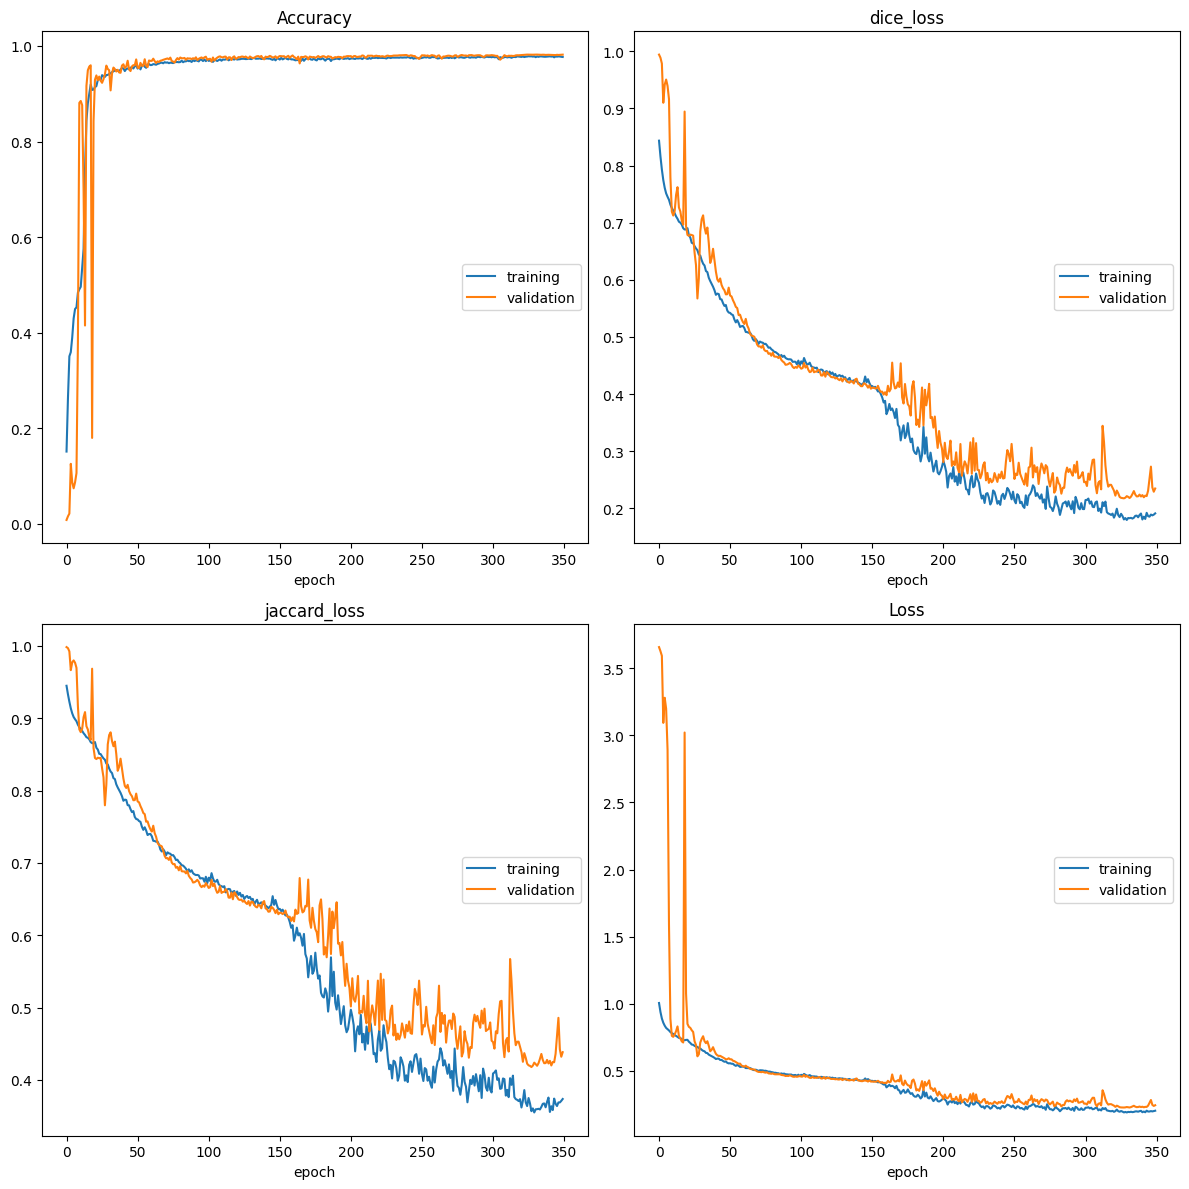

Accuracy
	training         	 (min:    0.151, max:    0.978, cur:    0.977)
	validation       	 (min:    0.008, max:    0.982, cur:    0.982)
dice_loss
	training         	 (min:    0.179, max:    0.844, cur:    0.191)
	validation       	 (min:    0.217, max:    0.994, cur:    0.235)
jaccard_loss
	training         	 (min:    0.355, max:    0.945, cur:    0.374)
	validation       	 (min:    0.418, max:    0.998, cur:    0.438)
Loss
	training         	 (min:    0.190, max:    1.006, cur:    0.203)
	validation       	 (min:    0.227, max:    3.657, cur:    0.244)
6/6 [==============================] - 7s 1s/step - loss: 0.2033 - Accuracy: 0.9770 - dice_loss: 0.1910 - jaccard_loss: 0.3737 - val_loss: 0.2441 - val_Accuracy: 0.9818 - val_dice_loss: 0.2346 - val_jaccard_loss: 0.4384


In [8]:

## early stoping and checkpoint also init the plotloss function
early_stop = EarlyStopping(monitor='val_loss', patience=pat, mode='min')
logdir = os.path.join("logs", model_name.rsplit("_",19)[0])
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#
## name the model
filepath="D:\Prateek\MICROSCOPY_AI_Cryoinjuries-main\Models\{}_CiAnalysis_BestWeights_".format(datetime.date.today())+model_name+".hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

plotlosses = PlotLossesKeras()


callbacks_list = [checkpoint, early_stop,plotlosses,tensorboard_callback]

# Train the model, doing validation at the end of each epoch.

model.fit(train_dataloader, validation_data=valid_dataloader, validation_steps=vsteps, steps_per_epoch=epsteps, epochs=epochs, callbacks=callbacks_list)

# 5. Load the best model from your training

In [9]:
# working with sm.model resnet18 and image as integer
model=load_model("D:\Prateek\MICROSCOPY_AI_Cryoinjuries-main\Models\{}_CiAnalysis_BestWeights_".format(datetime.date.today())+model_name+".hdf5",custom_objects={'dice_loss':dice_loss,'jaccard_loss':loss_func[0],'dice_loss_plus_2focal_loss':total_loss})

In [10]:
"D:\Prateek\MICROSCOPY_AI_Cryoinjuries-main\Models\{}_CiAnalysis_BestWeights_".format(datetime.date.today())+model_name+".hdf5"

'D:\\Prateek\\MICROSCOPY_AI_Cryoinjuries-main\\Models\\2022-11-15_CiAnalysis_BestWeights_bb_resnet18__trainSz_180__lossfun_dice_loss_plus_2focal_loss__lr_0.0001__act_softmax__batchsz_30__pat-50__epo-350_vstep-2_epstep-6_comment_nick_slide_scanner_15112022.hdf5'

# 6. Evaluate your model with the Test data
the Test data have never been seen by the network before

In [11]:
x_test_dir = os.path.join(path_data, "Images", "Images_Test")
y_test_dir = os.path.join(path_data, "Annotations","Annotations_Test")


test_dataset = TDL.Dataset(
    x_valid_dir, 
    y_valid_dir,  
    augmentation=TDL.get_validation_augmentation(),
    preprocessing=TDL.get_preprocessing(preprocess_input),
)

# 7. Make predictions to your Test data

In [12]:
test_dataloader = TDL.Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
preds=model.predict(test_dataloader)

2/2 [==============================] - 1s 374ms/step


# 8. Make an overall evaluation of your model on the Test data the Loss should be as low as possible

In [13]:
model.evaluate(test_dataloader)

2/2 [==============================] - 1s 284ms/step - loss: 0.2272 - Accuracy: 0.9814 - dice_loss: 0.2173 - jaccard_loss: 0.2272


[0.2272433340549469,
 0.9813644886016846,
 0.2173372507095337,
 0.2272433191537857]

# 9. Here you can see actual segmentations of the Test data

In [22]:
batch= 1
im_number = 0

batch= 1
im_number = 6

batch= 1
im_number = 16


batch= 1
im_number = 17

batch= 1
im_number = 29

batch= 0
im_number = 3

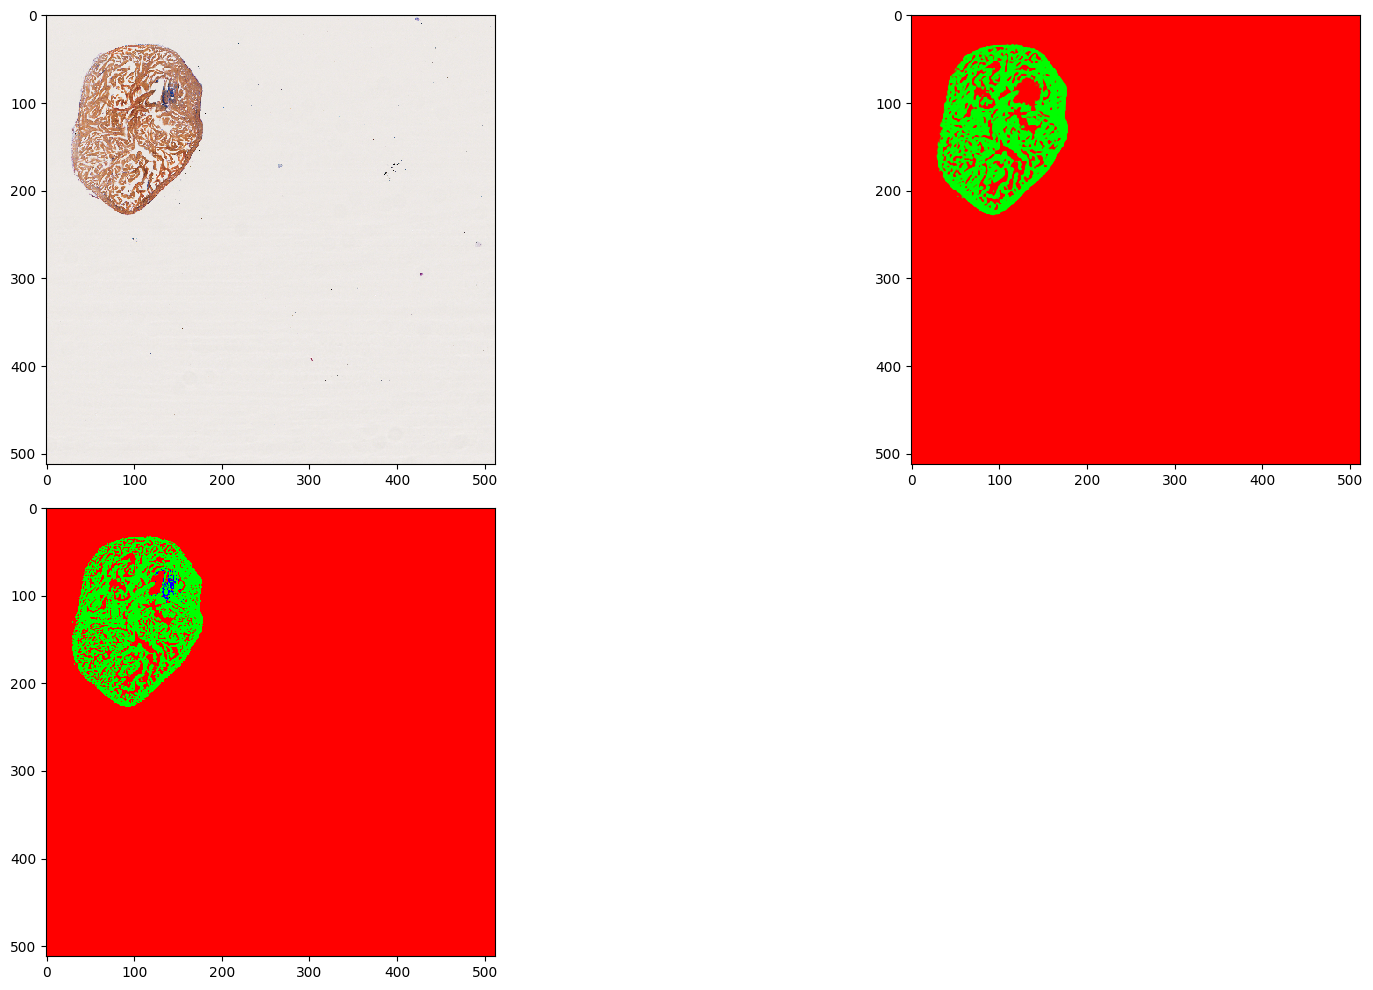

In [140]:
test_dataloader = TDL.Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

batch= 1
im_number = 0


if batch==1:
    im_number_pred = 30+im_number
if batch==0:
    im_number_pred = im_number

im_test = test_dataloader[batch][0][im_number] 
annot_ref = test_dataloader[batch][1][im_number]
preds_t = preds[im_number_pred]

plt.figure(figsize=(20,10))
plt.subplot(221)
imshow(im_test)

plt.subplot(222) 
imshow(preds_t)

plt.subplot(223)
imshow(annot_ref)

# 10. Calculate a threshold for the CI and the ventricle

try it for different images with CI and Ventricle

In [90]:
# To help
def set_thresh(preds_test, annot,t, structure="CI"):
    if structure == "CI":
        preds_test = (preds_test[:,:,2] > t).astype(int)
        annot = (annot[:,:,2]/255).astype(int)
    if structure == "Ventricle":
        preds_test = (preds_test[:,:,1] > t).astype(int)
        annot = (annot[:,:,1]/255).astype(int)  
    
    summed = np.sum((preds_test + annot) == 2)
    
    out = summed / np.sum(preds_test)
    return out


sub_ci = [(i,np.sum(set_thresh(preds_t,annot_ref, i))) for i in np.arange(0,1,0.01)]

for i in np.arange(0,1,0.01):
    # print(i)
    # if structure == "CI":
    preds_test = (preds_t[:,:,2] > i).astype(int)
    annot = (annot_ref[:,:,2]/255).astype(int)
    
    
    
# thresh_ci = [a[0] for a in sub_ci]
# overlap_ratio_ci = [a[1] for a in sub_ci]

# sub_ve = [(i,np.sum(set_thresh(preds_t,annot_ref, i, structure="Ventricle"))) for i in np.arange(0,1,0.01)]
# thresh_ve = [b[0] for b in sub_ve]
# overlap_ratio_ve = [b[1] for b in sub_ve]

# plt.subplot(121)
# plt.plot(thresh_ci , overlap_ratio_ci)
# plt.plot(thresh_ci[np.nanargmax(overlap_ratio_ci)], np.nanmax(overlap_ratio_ci), 'ro')
# plt.title("CI")

# print("CI",
#     "threshold:", thresh_ci[np.nanargmax(overlap_ratio_ci)] ,
#       "overlap_ratio:", np.nanmax(overlap_ratio_ci))

# plt.subplot(122)
# plt.plot(thresh_ve , overlap_ratio_ve)
# plt.plot(thresh_ve[np.nanargmax(overlap_ratio_ve)], np.nanmax(overlap_ratio_ve), 'ro')
# plt.title("Ventricle")
# print("Ventricle",
#     "threshold:", thresh_ve[np.nanargmax(overlap_ratio_ve)] ,
#       "overlap_ratio:", np.nanmax(overlap_ratio_ve))


C:\Users\pa20c964\AppData\Local\Temp\ipykernel_37660\4052964561.py:12: RuntimeWarning: invalid value encountered in long_scalars
  out = summed / np.sum(preds_test)


In [10]:
!pip freeze > F:/Alex/GitHub/environment.txt